## LAMINI Narimene - GUETTAF Sarah - G4

# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.

# Importation des librairies necessaires au travail

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [86]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [87]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X = data[:,:-1]
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [88]:
print('X', X.shape ,' y ', y.shape)

X (5000, 400)  y  (5000, 1)


Visualisation aléatoire de quelques données

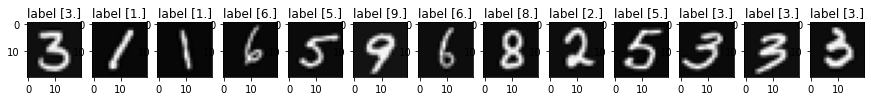

In [89]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,0:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')   


Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [90]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [91]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

# Réseaux de neurones
Pour cette partie, nous choisissons un réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [92]:
# poids de la couche 1
weights_layer_1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1 = weights_layer_1[:,1:]
B1 = (weights_layer_1[:,0])
W1.shape

(25, 400)

In [93]:
# poids de la couche 2
weights_layer_2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2 = weights_layer_2[:,1:]
B2 = (weights_layer_2[:,0])
W2.shape


(10, 25)

In [94]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [95]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z));

In [96]:
def computeCost(X, YY, W1, B1, W2, B2,hidden_layer_size, lambda_):
    
    Z1 = np.dot(X,W1.T) + B1
    A1 = Sigmoid(Z1)
    Z2 =  np.dot(A1,W2.T) + B2
    A2 = Sigmoid(Z2)
    
    #calculer le cout  en utilisant les poids intitiaux (W1 et W2)
    cost = (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(A2))-((1-YY)*np.log(1-A2)))))
    
    #récupérer les paramètres initiaux
    parameters={'Z1' :Z1,'A1' :A1,'Z2' :Z2,'A2' :A2}
    
    #calculer la partie de la régularisation
    penalty = (lambda_ * (np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(B1))+np.sum(np.square(B2))) ) 
    / (2*(1/YY.shape[0]))
    
    #mettre à jour le cout en ajoutant la partie de régularisation
    cost_with_regularization = cost+ penalty
    
    return cost,cost_with_regularization,parameters

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [97]:
def NNCostFunction(X, YY, W1, B1, W2, B2,hidden_layer_size, lambda_):
    
  #récupérer le cout et les poids initialement calculés
    cost,cost_with_regularization,parameters = computeCost(X, YY, W1, B1, W2, B2,hidden_layer_size, lambda_)
    A1 = parameters['A1']
    A2 = parameters['A2']
    
    m = YY.shape[0] #5000
    
    #pour la couche de sortie
    dZ2 = A2 - YY                                        
    dW2 = (1/m) * np.dot(A1.T,dZ2)                    
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)    
    
     #pour la couche cachée
    dZ1 = np.dot(dZ2, W2) * (1 - A1*(A1-1))       
    dW1 = (1/m) * np.dot(X.T,dZ1)                       
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)  
    
    #mise à jour des paramètres
    grad_parameters = {'db1' : db1,'dW1' : dW1.T,'db2' : db2,'dW2' : dW2.T }

    return cost,cost_with_regularization, grad_parameters


# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [98]:
def gradientDescent(X, YY, W1, B1, W2, B2, alpha, iterations,lambda_):
    
    #initialisations
    cost_list = np.zeros((iterations,1))
    cost_list_with_regularization = np.zeros((iterations,1))
    
    for i in range(iterations):
        #recupérer le cout avec et sans régularisation en faisant appel à la fonction NNCostFunction
        cost,cost_with_regularization,grad_parameters = NNCostFunction(X, YY, W1, B1, W2, B2,hidden_layer_size, lambda_)
        cost_list[i] = cost
        cost_list_with_regularization [i] =cost_with_regularization
        
        dW1 = grad_parameters['dW1']
        db1 = grad_parameters['db1']
        dW2 = grad_parameters['dW2']
        db2 = grad_parameters['db2']
        
        #mise à jour des paramètres du réseau
        W1 = W1 - alpha * dW1
        B1 = B1 - alpha * db1
        W2 = W2 - alpha * dW2
        B2 = B2 - alpha * db2
    
    final_parameters = {'W1' : W1,'B1' : B1,'W2' : W2,'B2' : B2 }

    return cost_list,cost_list_with_regularization,final_parameters   
    

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [82]:
alpha =  0.01
iterations = 10000
lambda_ = 0.1

cost_list,cost_list_with_regularization,final_parameters =gradientDescent(X, YY, W1, B1, W2, B2, alpha, iterations,lambda_)
print("Le cout avec régularisation : ",cost_list_with_regularization)
print("Le cout sans régularisation : ", cost_list)


Le cout avec régularisation :  [[ 107.29987861]
 [3696.0476617 ]
 [3695.82139684]
 ...
 [3763.91376318]
 [3763.92444672]
 [3763.93513078]]
Le cout sans régularisation :  [[10.44143394]
 [10.38268791]
 [10.32281346]
 ...
 [ 0.54386462]
 [ 0.54385293]
 [ 0.54384123]]


In [99]:
print("Best cost :",cost_list[iterations-1] )

Best cost : [0.54384123]


# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [77]:
def predict (final_parameters, X):
    
    y_pred = np.zeros((X.shape[0],1))
    W1 = final_parameters['W1']
    B1 = final_parameters['B1']
    W2 = final_parameters['W2']
    B2 = final_parameters['B2']
   
    Z1 = np.dot(X,W1.T) + B1
    A1 = Sigmoid(Z1)
    Z2 =  np.dot(A1,W2.T) + B2
    A2 = Sigmoid(Z2)
    
    for i in range(X.shape[0]):
        y_pred[i] = np.where(A2[i,:]==np.amax( A2[i,:])) 
    

    return y_pred

In [78]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)

y_pred=predict (final_parameters, X)
precision = np.mean(y==y_pred)*100
print('Precision avec notre model : '+str(precision)+' %' )

<ipython-input-77-336fb2693410>:15: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  y_pred[i] = np.where(A2[i,:]==np.amax( A2[i,:]))


Precision using our model : 92.5 %


# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [73]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score

mlp = MLPClassifier(hidden_layer_sizes=(25,10), activation='logistic', solver='lbfgs', max_iter=1000)
mlp.fit(X,YY)

predict_train = mlp.predict(X)
precision_sicketlearn = np.mean(precision_score(YY, predict_train,average=None))
print('Precision avec sicketlearn : '+str(precision_sicketlearn*100)+' %' )

Precision avec sicketlearn : 99.95991967871485%


### On remarque que la précision calculée par notre modèle est proche de celle retournée par sklearn, ceci confirme la réussite de notre apprentissage.

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la première colonne, celle du biais)

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

- Ajouter plus de couches cachées 
- Faire entrainer le modèle en plusieurs itérations

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le Mercredi 11 Mai 2022 à 22h


# Bonne chance